# Static Labor Supply

# Setup

In [1]:
import numpy as np
from scipy.optimize import minimize

import matplotlib.pyplot as plt

from consav.linear_interp import interp_1d

## Utility and Parameters

In [2]:
# utility
def util(h,w,N,par):
    C = income(h,w,N,par)
    return (C**(1.0+par.eta))/(1.0+par.eta) - par.beta*(h**(1.0+par.gamma))/(1.0+par.gamma)

# income
def income(h,w,N,par):
    return (1.0-par.tau)*w*h + N

# solution
def solve(w,N,par):
    obj = lambda h: -util(h,w,N,par)
    h_init = np.array([2.0])

    bounds = ((0.0,200.0),)

    res = minimize(obj,h_init,bounds=bounds,method='SLSQP')
    h_opt = res.x[0]
    return h_opt

def solve_vec(N,par):

    h_vec = np.nan + np.ones(par.w_grid.size)
    for iw,w in enumerate(par.w_grid):
        h_vec[iw] = solve(w,N,par)
        
    return h_vec

In [3]:
# parameters 
class par: pass
par.beta = 0.1
par.eta = -2.0
par.gamma = 2.5
par.tau = 0.1

## In-Class Exercise
1. Look at the code and talk about it with the person next to you for 5 minutes
2. Write at least one question

## Solve Static Model on Grid of Wages, $w$

In [4]:
# find optimal labor supply as a function of wages
par.w_grid = np.linspace(1.0,20.0,100)

N = 5.0 # non-labor income. Important for strength of income effect
sol_h = solve_vec(N,par)

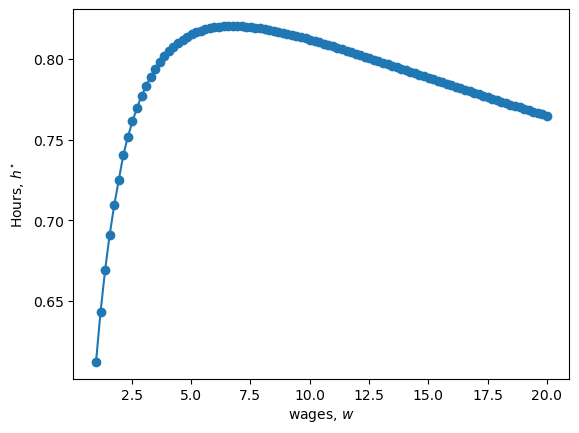

In [5]:
# plot solution
fig, ax = plt.subplots()
ax.plot(par.w_grid,sol_h,marker='o');
ax.set(xlabel='wages, $w$',ylabel='Hours, $h^{\star}$');

**Question 1:** At what level of wages does the income effect start to dominate?

**Question 2:** Plot the solution for different levels of non-labor income, $N$. How does the optimal behavior change? What about the income effect?

## Simulation
To simulate from this model, we need a level of non-labor income, $N$, and a wage level, $w$. We will primarely focus on the latter. 

The simulation here is simple, since we just need to *interpolate* the found solution for the new value of $w$ which is likely not on the grid `par.w_grid`, for which we have calculated the solution.

In [6]:
def simulate(wi,sol_h_vec,par):
    return interp_1d(par.w_grid,sol_h_vec,wi)

## Elasticities
**Marshall**

In [7]:
# Theoretical Marshall elasticities
S = ((1-par.tau)*par.w_grid*sol_h) / ((1-par.tau)*par.w_grid*sol_h + N)
ela_M = (1+par.eta*S) / (par.gamma - par.eta*S)

In [8]:
# Simulate one point on this curve. One observation is enough because no heterogeneity
w = 5.0
h_sim_base = simulate(w,sol_h,par) 
h_sim_1pct = simulate(w*1.01,sol_h,par) 

ela_M_sim = (h_sim_1pct-h_sim_base)/h_sim_base*100

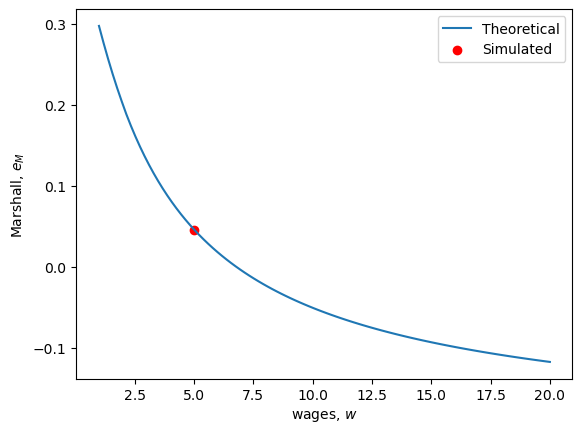

In [9]:
# plot
fig, ax = plt.subplots()
ax.plot(par.w_grid,ela_M,label='Theoretical');
ax.scatter(w,ela_M_sim,color='red',label='Simulated');
ax.set(xlabel='wages, $w$',ylabel='Marshall, $e_{M}$');
ax.legend();

**Income effect**

In [10]:
# Theoretical
ei = par.eta*S/(par.gamma - par.eta*S) 

In [11]:
# Solve and simulate model with slightly higher non-labor income
h_N = solve_vec(N*1.01,par)
h_sim_1pct_N = simulate(w,h_N,par)

ela_I_sim = (h_sim_1pct_N-h_sim_base)/h_sim_base*100
ei_sim = w*h_sim_base*(1-par.tau)* ela_I_sim / N

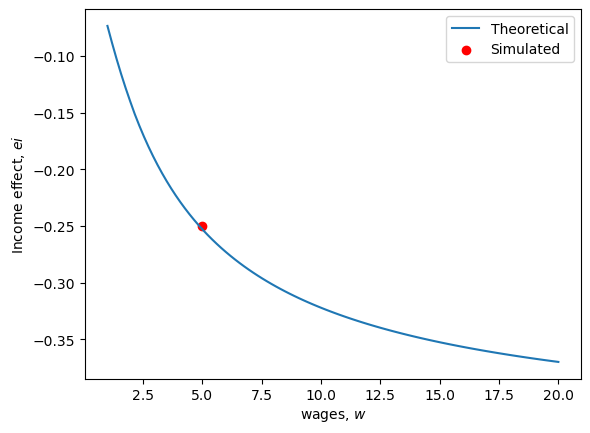

In [12]:
# plot
fig, ax = plt.subplots()
ax.plot(par.w_grid,ei,label='Theoretical');
ax.scatter(w,ei_sim,color='red',label='Simulated');
ax.set(xlabel='wages, $w$',ylabel='Income effect, $ei$');
ax.legend();

**Hicks, compensated elasticity**

In [13]:
# Theoretical
ela_H = 1/(par.gamma - par.eta*S)

In [14]:
# Hicks: Compensate (or use Slutsky, which is much easier)
def util_diff(comp,h_base,w,N,par):
    
    util_base = util(h_base,w,N,par)
    
    # alternative model: increase wage by 1% but compensate via non-labor income
    N_alt = N + comp
    w_alt = w*1.01
    
    h_alt = solve(w_alt,N_alt,par)
    util_alt = util(h_alt,w_alt,N_alt,par)
    
    return util_base - util_alt

In [15]:
# find the compensation that equalize utility to baseline level
obj = lambda comp: 1000.0*util_diff(comp,h_sim_base,w,N,par)**2 # squared utility difference (scaled)
res = minimize(obj,0.0)
comp = res.x[0]

print(f'Compensation: {comp:2.4f}. Resulting utility difference: {util_diff(comp,h_sim_base,w,N,par):2.2g}')

Compensation: -0.0367. Resulting utility difference: -3.2e-08


In [16]:
# calculate elasticity with this level of compensation
h_sim_1pct_H = solve(w*1.01,N+comp,par)
ela_H_sim = (h_sim_1pct_H-h_sim_base)/h_sim_base*100

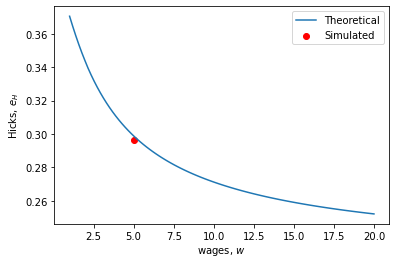

In [17]:
# plot
fig, ax = plt.subplots()
ax.plot(par.w_grid,ela_H,label='Theoretical');
ax.scatter(w,ela_H_sim,color='red',label='Simulated');
ax.set(xlabel='wages, $w$',ylabel='Hicks, $e_H$');
ax.legend();

## In-Class Exercise
Imagine that there is 1,000 heterogeneous agents with individual levels of wages, $w_i$ for $i=1,\dots,1,000$. The distribution of wages is uniform on $[2.5,10.0]$. 

What is the average Marshall elasticity in the population? <br>
\[*hint:* you can calculate this by simulation using `np.randon.uniform`\]

In [18]:
# WRITE YOUR CODE HERE
n = 1000
w_rand = np.random.uniform(2.5,10.0,n)

# Simulate one point on this curve. One observation is enough because no heterogeneity
# w = 5.0

h_sim_base_array = np.zeros(n)
h_sim_1pct_array = np.zeros(n)
for wi,w in enumerate(w_rand):
    h_sim_base_array[wi] = simulate(w,sol_h,par) 
    h_sim_1pct_array[wi] = simulate(w*1.01,sol_h,par) 

ela_M_sim_array = (h_sim_1pct_array-h_sim_base_array)/h_sim_base_array*100
print(ela_M_sim_array.mean())

0.01997731318923641


## solution

In [19]:
# solution
n = 1_000

# draw uniform wages
np.random.seed(2023)
wi = np.random.uniform(2.5,10.0,size=n)

# find baseline optimal labor supply and alternative
hi_base = np.nan + np.ones(n)
hi_1pct = np.nan + np.ones(n)
for i in range(n):
    hi_base[i] = simulate(wi[i],sol_h,par)
    hi_1pct[i] = simulate(wi[i]*1.01,sol_h,par)
    
# individual elasticities
ela_M_i = (hi_1pct-hi_base)/hi_base*100

# average
print(f'Average Marshall: {np.mean(ela_M_i):2.3f}')

Average Marshall: 0.021


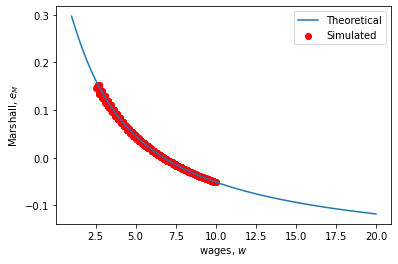

In [20]:
# plot individual with theoretical
fig, ax = plt.subplots()
ax.plot(par.w_grid,ela_M,label='Theoretical');
ax.scatter(wi,ela_M_i,color='red',label='Simulated');
ax.set(xlabel='wages, $w$',ylabel='Marshall, $e_{M}$');
ax.legend();